# **Regularização no PyTorch**
### Agora, usamos alguns métodos de regularização em nossa CNN Fashion-MNIST

Primeiro aprenderemos a criar um **modelo simples de rede neural convolucional** no PyTorch e a treiná-lo para **classificar imagens no conjunto de dados Fashion-MNIST**, agora **COM** o uso de qualquer método de regularização. 
1. Importe as bibliotecas do PyTorch, defina nossos transformadores, carregue nosso conjunto de dados e visualize nossas imagens.
2. Crie uma CNN simples com os seguintes métodos de **regularização**:
  - Regularização L2
  - Aumento de dados
  - Dropout
  - BatchNorm
3. Treinamento de nossa CNN com regularização


In [8]:
# Import PyTorch
import torch
import PIL
import numpy as np

# We use torchvision to get our dataset and useful image transformations
import torchvision
import torchvision.transforms as transforms

# Import PyTorch's optimization libary and nn
# nn is used as the basic building block for our Network graphs
import torch.optim as optim
import torch.nn as nn

# Are we using our GPU?
print("GPU available: {}".format(torch.cuda.is_available()))

GPU available: True


In [9]:
device = 'cuda' #'cpu' if no GPU available

# **2. Criando uma CNN com regulamentação**
## **Implementando o aumento de dados**

#### **Entendendo o que as nossas transformações fazem**

1. Nossas transformações são aplicadas a uma imagem ou a um lote de imagens sempre que ela é carregada.
2. Essas novas imagens não são salvas, elas são geradas ou “alteradas” sempre que um lote é carregado

#### **NOTA** 

Não aplicamos as mesmas ampliações aos nossos conjuntos de dados de teste ou de validação. Portanto, mantemos funções de transformação separadas (veja abaixo) para nossos dados de treinamento e validação/teste.

### Aumentos geométricos e fotométricos
https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#

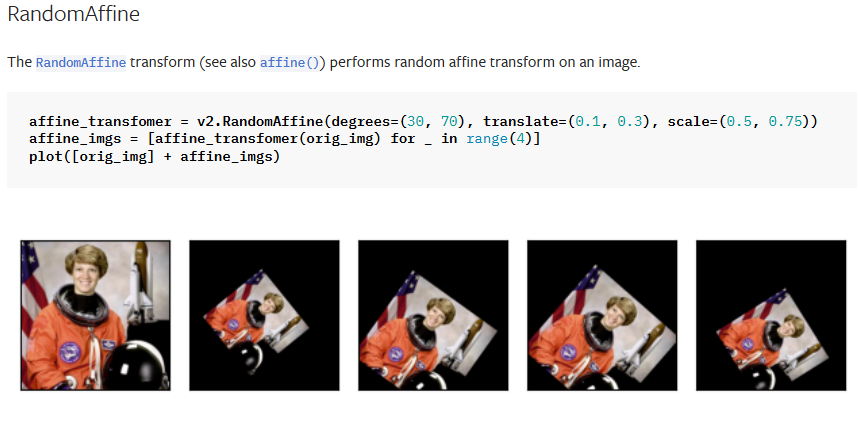

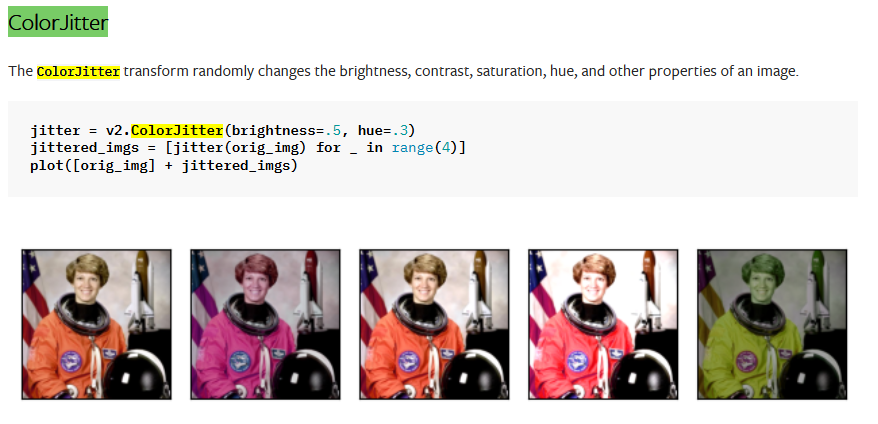

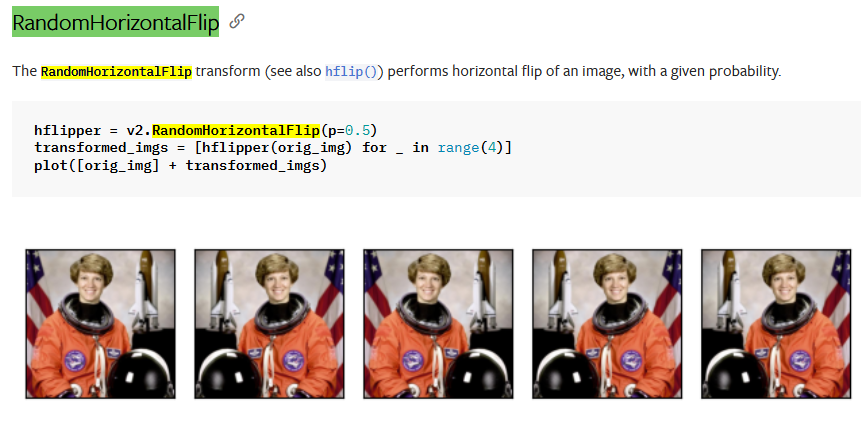

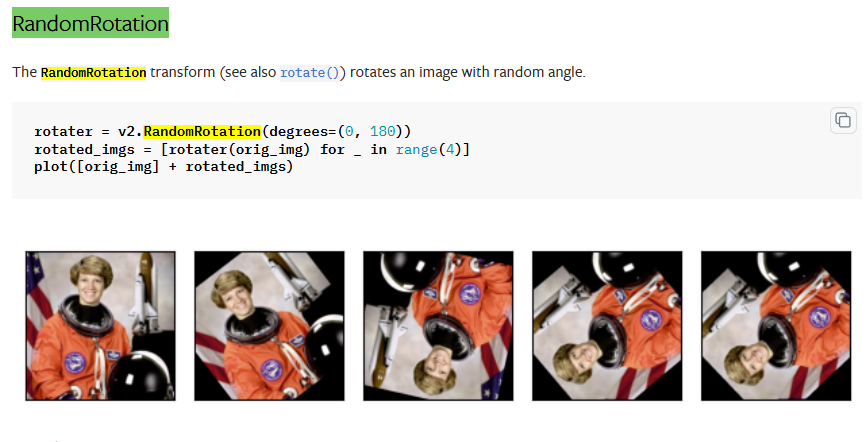

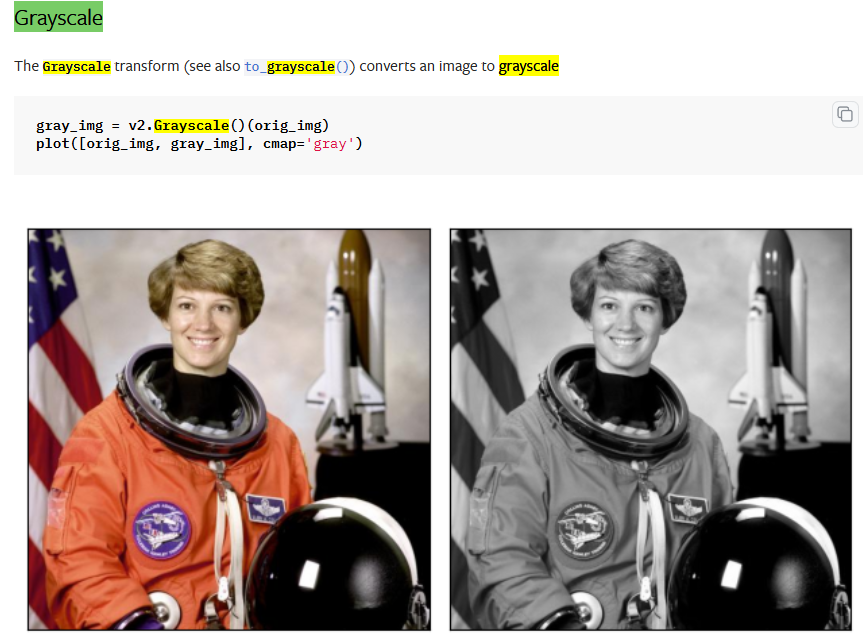


In [4]:
data_transforms = {
    'train': transforms.Compose([
        # Observe que elas são executadas na ordem em que são chamadas aqui
        # Algumas dessas transformações retornam uma imagem colorida, por isso precisamos converter
        # a imagem de volta para tons de cinza
        
        transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5), 
        transforms.ColorJitter(hue = .05, saturation = .05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15, interpolation = PIL.Image.BILINEAR),
        transforms.Grayscale(num_output_channels = 1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ])
}

In [6]:
# Carregar nossos dados de treino e especificar qual transformação usar ao carregar
trainset = torchvision.datasets.FashionMNIST(root='./fashion', train=True,
                                        download=True, transform=data_transforms['train'])

# Carregar nossos dados de teste e especificar qual transformação usar ao carregar
testset = torchvision.datasets.FashionMNIST(root='./fashion', train=False,
                                       download=True, transform=data_transforms['val'])

# Prepare train and test loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

100%|██████████| 26.4M/26.4M [00:04<00:00, 5.49MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 58.9MB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.62MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.5MB/s]


### **Adicionando Dropout**

Nas redes neurais convolucionais, o dropout é comumente adicionado após as camadas CONV-RELU.

Por exemplo, CONV->RELU->**DROPOUT**

#### **Dropout Recommendations** 

Em CNNs, valores de 0,1 a 0,3 têm funcionado bem.

### **Adicionar BatchNorm**

Nas CNNs, o **BatchNorm** é melhor usado entre a camada de Convolução e a camada de função de ativação (ReLU)
Quando usado com Dropout, a ordem recomendada é: 

CONV_1 -> **BatchNorm** -> ReLU -> Dropout - CONV_2

**NOTA** O argumento de entrada do BatchNorm é o tamanho da **saída** da camada anterior.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        # Adicionando BatchNorm, usando 32 como entrada, já que 32 foi a saída de nossa primeira camada de Conv.
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Adicionando o BatchNorm, usando 64 como entrada, já que 64 foi a saída de nossa primeira camada de Conv.
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        # Definindo nossa função de dropout com uma taxa de 0,2
        # Podemos aplicar isso depois de qualquer camada, mas é mais adequado depois do ReLU
        self.dropOut = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.dropOut(x)
        x = self.dropOut(F.relu(self.conv2_bn(self.conv2(x))))

        x = self.pool(x)
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

### **Adicionando a regularização L2**


A regularização L2 nos parâmetros/pesos do modelo é incluída diretamente na maioria dos otimizadores, incluindo o optim.SGD.

Ela pode ser controlada com o parâmetro **weight_decay**, como pode ser visto na [documentação do SGD] (http://pytorch.org/docs/optim.html#torch.optim.SGD).

``weight_decay`` (**float**, opcional) - decaimento do peso *(penalidade L2) (padrão: 0)*

**Bons valores de L2 variam de 0,1 a 0,0001**

**NOTA:**

 A regularização L1 não é incluída por padrão nos otimizadores, mas pode ser adicionada por meio da inclusão de uma perda extra nn.L1Loss nos pesos do modelo.

In [11]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.001)

# **3. Treinamento do nosso modelo usando métodos de regulação - aumento de dados, dropout, BatchNorm e regularização L2**

In [13]:

epochs = 15

epoch_log = []
loss_log = []
accuracy_log = []


for epoch in range(epochs):  
    print(f'Iniciando treino na época: {epoch+1}...')

    # Continuamos adicionando ou acumulando nossa perda após cada mini-lote em running_loss
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # obtenha as entradas; os dados são uma lista de [entradas, rótulos]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        # Forward -> backprop + optimize
        outputs = net(inputs) # Forward Propagation 
        loss = criterion(outputs, labels) # Obter perdas (quantificar a diferença entre os resultados e as previsões)
        loss.backward() # Propagar de volta para obter os novos gradientes para todos os nós
        optimizer.step() # Atualizar os gradientes/pesos

        # Print Training statistics - Epoch/Iterations/Loss/Accurachy
        running_loss += loss.item()
        if i % 100 == 99:    # Mostrar a Loss a cada 50 mini-batches
            correct = 0 # Contando predições certas
            total = 0 # Contando os rotulos iterados

            # Contexto no_grad
            with torch.no_grad():
                # Interando sobre o loader de teste
                for data in testloader:
                    images, labels = data
                    
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # Pegando as probabilidades das predições
                    outputs = net(images)

                     # Pegando as maiores probabilidades
                    _, predicted = torch.max(outputs.data, 1)
                    # adicionando o tamanho ou o comprimento do rotulo à variável total
                    total += labels.size(0)
                    # Mantenha um total contínuo do número de previsões feitas corretamente
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Época: {epoch_num}, Mini-Batches completados: {(i+1)}, Loss: {actual_loss:.3f}, Acurácia de teste = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Treino completado')

Iniciando treino na época: 1...
Época: 1, Mini-Batches completados: 100, Loss: 2.382, Acurácia de teste = 73.460%
Época: 1, Mini-Batches completados: 200, Loss: 1.632, Acurácia de teste = 75.970%
Época: 1, Mini-Batches completados: 300, Loss: 1.488, Acurácia de teste = 76.590%
Época: 1, Mini-Batches completados: 400, Loss: 1.353, Acurácia de teste = 76.730%
Época: 1, Mini-Batches completados: 500, Loss: 1.359, Acurácia de teste = 73.400%
Época: 1, Mini-Batches completados: 600, Loss: 1.276, Acurácia de teste = 79.400%
Época: 1, Mini-Batches completados: 700, Loss: 1.209, Acurácia de teste = 76.470%
Época: 1, Mini-Batches completados: 800, Loss: 1.325, Acurácia de teste = 78.390%
Época: 1, Mini-Batches completados: 900, Loss: 1.216, Acurácia de teste = 80.170%
Época: 1, Mini-Batches completados: 1000, Loss: 1.209, Acurácia de teste = 79.850%
Época: 1, Mini-Batches completados: 1100, Loss: 1.160, Acurácia de teste = 79.910%
Época: 1, Mini-Batches completados: 1200, Loss: 1.140, Acurácia 

In [14]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Acurácia da rede com 10000 imagens de teste: {accuracy:.4}%')

Acurácia da rede com 10000 imagens de teste: 90.06%


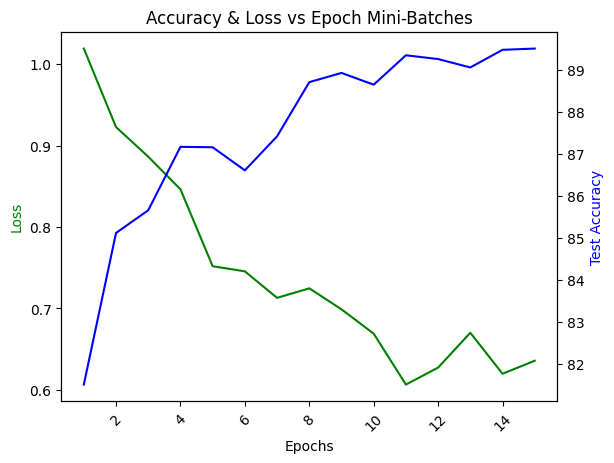

In [15]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()


plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

# TAREFA DE CASA: APLICAR O Early Stopping 

https://github.com/Bjarten/early-stopping-pytorch